In [1]:
import os
import sys
import cv2
import torch
import numpy as np
from numpy import *
from torch import nn
from torchvision import models
from torch.autograd import Variable
import torchvision.transforms as trans
import matplotlib.pyplot as plt
import multiprocessing
from tqdm import tqdm
import cifar10_models
import copy
import ssl

In [2]:
CF=[]
IMG=[]

In [3]:
IMAGENET_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

CIFAR_SIZE = 32
CIFAR_MEAN = [0.4914, 0.4822, 0.4465]
CIFAR_STD = [0.2023, 0.1994, 0.2010]

MNIST_SIZE = 28
MNIST_MEAN = [0.5]
MNIST_STD = [1.0]
def preprocess_image(cv2im,source='cifar'):
    if source == 'imagenet':
        mean = IMAGENET_MEAN
        std = IMAGENET_STD
    elif source == 'cifar':
        mean = CIFAR_MEAN
        std = CIFAR_STD
    elif source == 'mnist':
        mean = MNIST_MEAN
        std = MNIST_STD
    im_as_arr = np.float32(cv2im)
    im_as_arr = np.ascontiguousarray(im_as_arr[..., ::-1])
    im_as_arr = im_as_arr.transpose(2, 0, 1)
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    im_as_ten = torch.from_numpy(im_as_arr).float()
    im_as_ten.unsqueeze_(0)
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var


def recreate_image(im_as_var,source='cifar'):
    if source == 'imagenet':
        mean = IMAGENET_MEAN
        std = IMAGENET_STD
    elif source == 'cifar':
        mean = CIFAR_MEAN
        std = CIFAR_STD
    elif source == 'mnist':
        mean = MNIST_MEAN
        std = MNIST_STD
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] *= std[c]
        recreated_im[c] += mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)

    recreated_im = recreated_im[..., ::-1]
    return recreated_im


def get_params(original_image):
    prep_img = preprocess_image(original_image)
    return (original_image,
            prep_img)


In [4]:
def get_params_img(example_index):
    s = "%08d" % example_index
    img_path = sys.path[0]+'/../ILSVRC2012_img_val/ILSVRC2012_val_'+ s +'.JPEG'
    original_image = cv2.imread(img_path, 1)
    prep_img = preprocess_image(original_image,'imagenet')
    
    return (original_image,
            prep_img)


In [5]:
class cifar(torch.utils.data.Dataset):
    def __init__(self,data,label):
        self.images=data
        self.labels=torch.LongTensor(label)
    def __getitem__(self,index):
        img=self.images[index]
        img2=preprocess_image(img,source='cifar')
        label = self.labels[index]
        return img2, label

    def __len__(self):
        return (self.images.shape[0])


class FastGradientSignUntargeted():
    def __init__(self, model, alpha):
        self.model = model
        self.model.eval()
        self.alpha = alpha

    def generate(self, original_image, org_class, example_number,minimum=0.95):
        im_label_as_var = Variable(torch.from_numpy(np.asarray([org_class])))
        ce_loss = nn.CrossEntropyLoss()
        processed_image = preprocess_image(original_image)
        for i in range(30):
            processed_image.grad = None
            out = self.model(processed_image)
            pred_loss = -ce_loss(out, im_label_as_var)
            pred_loss.backward()
            adv_noise = self.alpha * torch.sign(processed_image.grad.data)
            processed_image.data = processed_image.data - adv_noise

            recreated_image = recreate_image(processed_image)
            prep_confirmation_image = preprocess_image(recreated_image)
            confirmation_out = self.model(prep_confirmation_image)
            _, confirmation_prediction = confirmation_out.data.max(1)
            confirmation_confidence = \
                nn.functional.softmax(confirmation_out,dim=1)[0][confirmation_prediction].data.numpy()[0]
            confirmation_prediction = confirmation_prediction.numpy()[0]
            if (confirmation_prediction != org_class) and (confirmation_confidence>minimum):
                noise_image = original_image - recreated_image
                return i+1

        return 0



In [6]:
class FastGradientSignUntargeted_img():
    def __init__(self, model, alpha):
        self.model = model
        self.model.eval()
        self.alpha = alpha

    def generate(self, original_image, org_class, example_number,minimum=0.95):
        im_label_as_var = Variable(torch.from_numpy(np.asarray([org_class])))
        ce_loss = nn.CrossEntropyLoss()
        processed_image = preprocess_image(original_image)
        for i in range(30):
            processed_image.grad = None
            out = self.model(processed_image)
            pred_loss = -ce_loss(out, im_label_as_var)
            pred_loss.backward()
            adv_noise = self.alpha * torch.sign(processed_image.grad.data)
            processed_image.data = processed_image.data - adv_noise

            recreated_image = recreate_image(processed_image)
            prep_confirmation_image = preprocess_image(recreated_image)
            confirmation_out = self.model(prep_confirmation_image)
            _, confirmation_prediction = confirmation_out.data.max(1)
            confirmation_confidence = \
                nn.functional.softmax(confirmation_out,dim=1)[0][confirmation_prediction].data.numpy()[0]
            confirmation_prediction = confirmation_prediction.numpy()[0]
            if (confirmation_prediction != org_class) and (confirmation_confidence>minimum):
                noise_image = original_image - recreated_image
                return i+1

        return 0



In [7]:
def cf10():
    pretrained_model = cifar10_models.vgg16_bn(pretrained=True)
    cat2lab=np.load(sys.path[0]+'/label.npy').item()
    FGS_untargeted=FastGradientSignUntargeted(pretrained_model,0.1)
    for index in range(1,2):
        ima=np.load(sys.path[0]+"/../data/databatch"+str(index)+".npy")
        lab=np.load(sys.path[0]+"/../data/label"+str(index)+".npy")
        for i in tqdm(range(500)):
            inputs=ima[i]
            labels=lab[i]
            (original_image, prep_img) = get_params(inputs)
            org_out=pretrained_model(prep_img)
            _,org_class=org_out.data.max(1)
            org_confidence=nn.functional.softmax(org_out,dim=1)[0][org_class].data.numpy()[0]
            org_class=org_class.numpy()[0]
            
            tmp=FGS_untargeted.generate(original_image, org_class,int(labels))
            CF.append(tmp)
            

In [8]:
def img():
    pretrained_model = models.vgg16(pretrained=True)
    FGS_untargeted=FastGradientSignUntargeted_img(pretrained_model,0.1)
    for i in tqdm(range(500)):
        target_example = i+1
        (original_image, prep_img) = get_params_img(target_example)
        
        label=np.load(sys.path[0]+'/label.npy').item()
        org_out=pretrained_model(prep_img)
        _,org_class=org_out.data.max(1)
        org_confidence=nn.functional.softmax(org_out,dim=1)[0][org_class].data.numpy()[0]
        org_class=org_class.numpy()[0]
        tmp=FGS_untargeted.generate(original_image, org_class,target_example)
        IMG.append(tmp)

100%|██████████| 500/500 [3:15:52<00:00, 78.30s/it]    
/Users/kyle/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 36845 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/kyle/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 20195 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/kyle/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:176: RuntimeWarning: Glyph 36845 missing from current font.
  font.load_char(ord(s), flags=flags)
/Users/kyle/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:176: RuntimeWarning: Glyph 20195 missing from current font.
  font.load_char(ord(s), flags=flags)


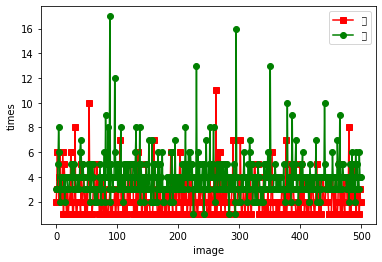

NameError: name 'mean' is not defined

In [9]:
cf10()
img()

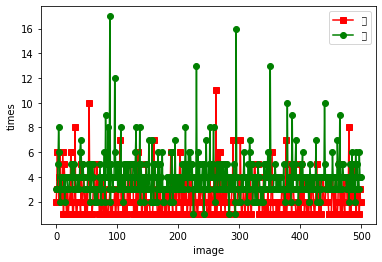

2.482
3.992


In [12]:
xi=[]
for i in range(500):
    xi.append(i)
plt.plot(xi,CF,'s-',color = 'r',label='cifar10')
plt.plot(xi,IMG,'o-',color = 'g',label='imagenet')
plt.xlabel("image")
plt.ylabel("times")
plt.legend("迭代次数")
plt.show()
print(mean(CF))
print(mean(IMG))

In [7]:
vgg19_CF=[]
vgg19_IMG=[]

In [ ]:
if __name__ == '__main__':
    pretrained_model = cifar10_models.vgg19_bn(pretrained=True)
    cat2lab=np.load(sys.path[0]+'/label.npy').item()
    FGS_untargeted=FastGradientSignUntargeted(pretrained_model,0.1)
    ima=np.load(sys.path[0]+"/../data/databatch"+str(1)+".npy")
    lab=np.load(sys.path[0]+"/../data/label"+str(1)+".npy")
    ii=[i for i in range(500)]
    def sol1(i):
        inputs=ima[i]
        labels=lab[i]
        (original_image, prep_img) = get_params(inputs)
        org_out=pretrained_model(prep_img)
        _,org_class=org_out.data.max(1)
        org_confidence=nn.functional.softmax(org_out,dim=1)[0][org_class].data.numpy()[0]
        org_class=org_class.numpy()[0]
        return FGS_untargeted.generate(original_image, org_class,int(labels))
    
    pool = multiprocessing.Pool(processes=4)
    vgg19_CF=list(tqdm(pool.imap(sol1,ii),total=500))
    pool.close()
    pool.join()
    pretrained_model = models.vgg19(pretrained=True)
    FGS_untargeted=FastGradientSignUntargeted_img(pretrained_model,0.1)
    #ii=[i for i in range(500)]
    
    def sol2(i):
        target_example = i+1
        (original_image, prep_img) = get_params_img(target_example)
        
        org_out=pretrained_model(prep_img)
        _,org_class=org_out.data.max(1)
        org_confidence=nn.functional.softmax(org_out,dim=1)[0][org_class].data.numpy()[0]
        org_class=org_class.numpy()[0]
        return FGS_untargeted.generate(original_image, org_class,target_example)
    
    pool = multiprocessing.Pool(processes=2)
    vgg19_IMG=list(tqdm(pool.imap(sol2,ii),total=500))
    pool.close()
    pool.join()
    


 38%|███▊      | 192/500 [1:02:11<1:06:59, 13.05s/it]

In [ ]:
xi=[]
for i in range(500):
    xi.append(i)
plt.plot(xi,vgg19_CF,'s-',color = 'r',label='cifar10')
plt.plot(xi,vgg19_IMG,'o-',color = 'g',label='imagenet')
plt.xlabel("vgg19")
plt.ylabel("times")
plt.legend("迭代次数")
plt.show()
print(mean(vgg19_CF))
print(mean(vgg19_IMG))